In [1]:
import pandas as pd
import visual_behavior.database as db
from visual_behavior.data_access import loading
import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import Pool
import itertools

In [2]:
%matplotlib inline

## get complimentary planes for a given session

In [3]:
def get_complimentary_planes(session):
    query = (f"""SELECT 
    os.id as session_id, 
    oe.id as exp_id,
    oe.ophys_imaging_plane_group_id as pair_id,
    oipg.group_order
    FROM ophys_sessions os
    JOIN ophys_experiments oe ON oe.ophys_session_id=os.id
    JOIN ophys_imaging_plane_groups oipg ON oipg.id=oe.ophys_imaging_plane_group_id
    WHERE os.id = {session}
    ORDER BY exp_id
    """)

    return db.lims_query(query)

In [4]:
session=952430817
pairs_df = get_complimentary_planes(session)
pairs_df

,session_id,exp_id,pair_id,group_order
0,952430817,953659741,994040710,0
1,952430817,953659743,994040710,0
2,952430817,953659745,994040711,1
3,952430817,953659747,994040711,1
4,952430817,953659749,994040712,2
5,952430817,953659752,994040712,2
6,952430817,953659754,994040713,3
7,952430817,953659756,994040713,3


## a function to determine if two cell ROIs are overlapping

In [5]:
def get_overlap(datasets, cell_0, cell_1):
    '''
    determine if two cell ROIs from two planes are overlapping
    inputs:
        list of datasets (length 2)
        cell_0 cell_specimen_id
        cell_1 cell_specimen_id
    returns dictionary with:
        'experiment_0': experiment 0 ID
        'cell_0': cell_0 id,
        'experiment_1': experiment 1 ID,
        'cell_1': cell_1 ID,
        'overlapped': Boolean, True if any overlap exists,
        'overlap_cell_0_fraction': fraction of cell 0 that is overlapped,
        'overlap_cell_1_fraction': fraction of cell 1 that is overlapped,
    '''
        
    overlap = np.logical_and(
        datasets[0].cell_specimen_table.loc[cell_0]['roi_mask'],
        datasets[1].cell_specimen_table.loc[cell_1]['roi_mask']
    ).sum()
                        
    return {
        'experiment_0': datasets[0].ophys_experiment_id,
        'cell_0': cell_0,
        'experiment_1': datasets[1].ophys_experiment_id,
        'cell_1': cell_1,
        'overlapped': overlap > 0,
        'overlap_cell_0_fraction': overlap/datasets[0].cell_specimen_table.loc[cell_0]['roi_mask'].sum(),
        'overlap_cell_1_fraction': overlap/datasets[1].cell_specimen_table.loc[cell_1]['roi_mask'].sum(),
    }

## find two complimentary planes

In [6]:
group_order = 2
datasets = []
for i in range(2):
    datasets.append(loading.get_ophys_dataset(pairs_df.query('group_order == {}'.format(group_order)).iloc[i]['exp_id']))

extracting cached data from 953659749_457841_190923_VISl_0_Sst-IRES-Cre_MESO.1_behavior_150
extracting cached data from 953659752_457841_190923_VISl_0_Sst-IRES-Cre_MESO.1_behavior_225


## visualize two planes and overlap (yellow in third plot = overlap)

Text(0.5, 1.0, 'sum of planes')

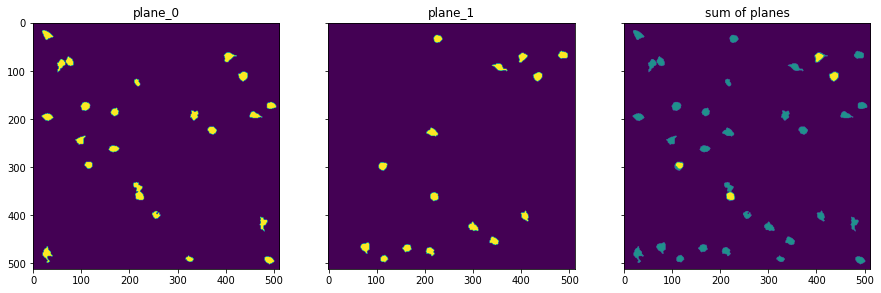

In [7]:
fig, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
ax[0].imshow(datasets[0].segmentation_mask_image)
ax[0].set_title('plane_0')
ax[1].imshow(datasets[1].segmentation_mask_image)
ax[1].set_title('plane_1')

ax[2].imshow(np.array(datasets[0].segmentation_mask_image) + np.array(datasets[1].segmentation_mask_image))
ax[2].set_title('sum of planes')

## get a dataframe for all cell combinations
overlapped column contains Boolean True if cells overlap

In [8]:
%%time
cell_combos = [[datasets, cell_0, cell_1] for cell_0, cell_1 in itertools.product(datasets[0].cell_specimen_ids, datasets[1].cell_specimen_ids)]
with Pool(32) as pool:
    overlaps = pd.DataFrame(pool.starmap(get_overlap, cell_combos))

CPU times: user 1.6 s, sys: 3.09 s, total: 4.69 s
Wall time: 7.08 s


In [9]:
overlaps.query('overlapped')

,experiment_0,cell_0,experiment_1,cell_1,overlapped,overlap_cell_0_fraction,overlap_cell_1_fraction
30,953659749,1065627120,953659752,1065651761,True,0.872222,0.679654
63,953659749,1065627500,953659752,1065652400,True,0.008811,0.008264
78,953659749,1065627712,953659752,1065652400,True,0.891129,0.913223
267,953659749,1065630794,953659752,1065654623,True,0.750000,0.903766
279,953659749,1065630967,953659752,1065653932,True,0.861702,0.952941


## visualize all overlapping cells

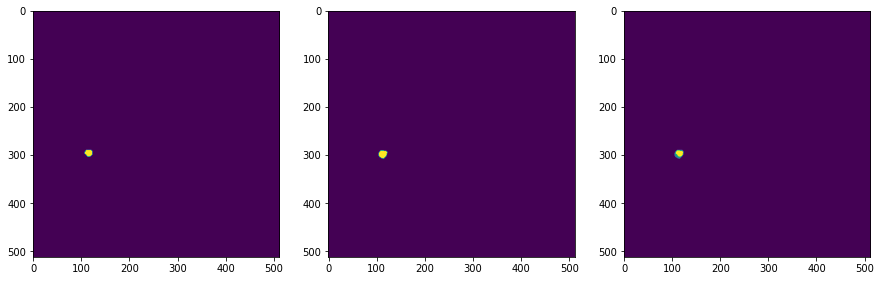

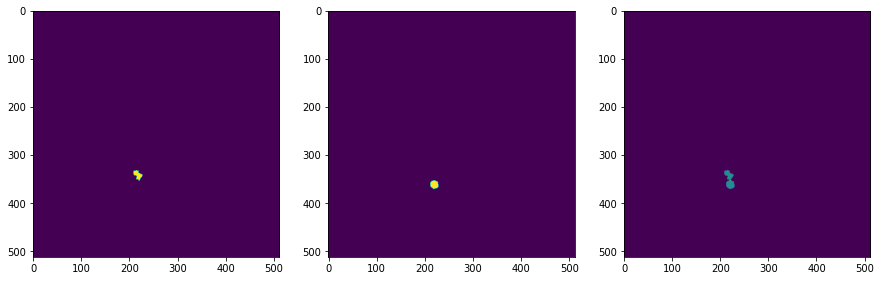

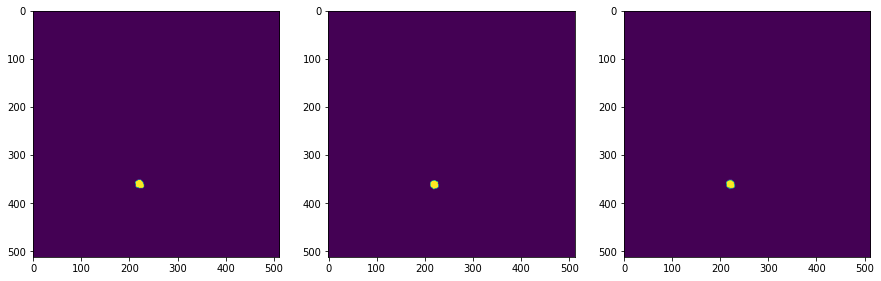

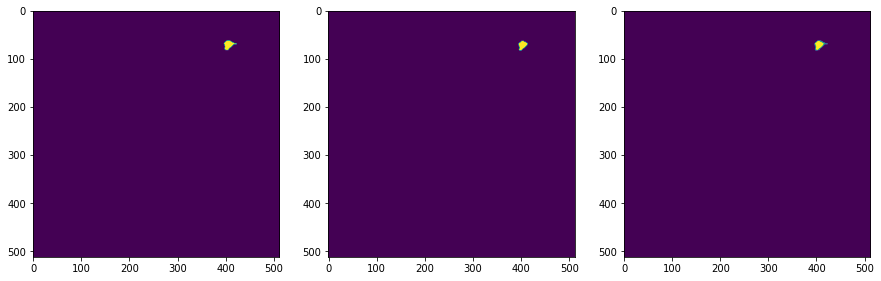

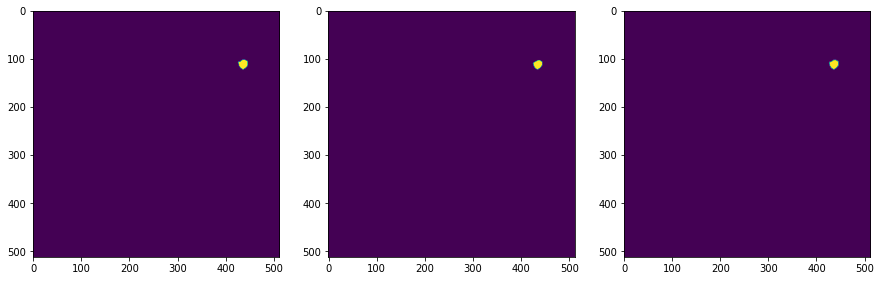

In [10]:
for idx, row in overlaps.query('overlapped').iterrows():
    fig,ax=plt.subplots(1,3,figsize=(15,5))

    mask_0 = datasets[0].cell_specimen_table.loc[row['cell_0']]['roi_mask']
    mask_1 = datasets[1].cell_specimen_table.loc[row['cell_1']]['roi_mask']
    ax[0].imshow(mask_0)
    ax[1].imshow(mask_1)
    ax[2].imshow(np.array(mask_0).astype(int) + np.array(mask_1).astype(int))

# repeat for an excitatory session

In [11]:
session = 985609503
pairs_df = get_complimentary_planes(session)

In [12]:
group_order = 2
datasets = []
for i in range(2):
    datasets.append(loading.get_ophys_dataset(pairs_df.query('group_order == {}'.format(group_order)).iloc[i]['exp_id']))

extracting cached data from 986518887_479839_191118_VISl_0_Slc17a7-IRES2-Cre_MESO.1_behavior_169
extracting cached data from 986518889_479839_191118_VISl_0_Slc17a7-IRES2-Cre_MESO.1_behavior_271


Text(0.5, 1.0, 'sum of planes')

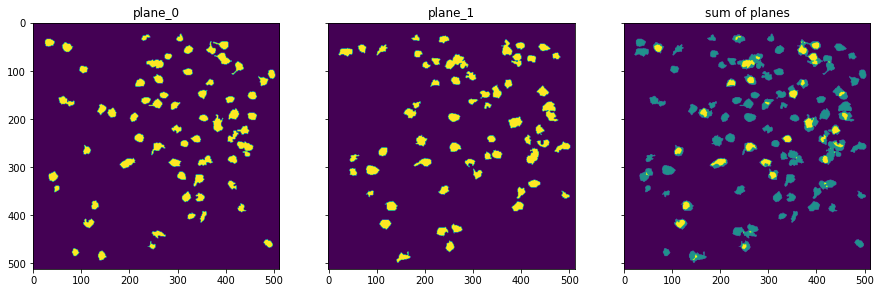

In [13]:
fig, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
ax[0].imshow(datasets[0].segmentation_mask_image)
ax[0].set_title('plane_0')
ax[1].imshow(datasets[1].segmentation_mask_image)
ax[1].set_title('plane_1')

ax[2].imshow(np.array(datasets[0].segmentation_mask_image) + np.array(datasets[1].segmentation_mask_image))
ax[2].set_title('sum of planes')

In [14]:
%%time
cell_combos = [[datasets, cell_0, cell_1] for cell_0, cell_1 in itertools.product(datasets[0].cell_specimen_ids, datasets[1].cell_specimen_ids)]
with Pool(32) as pool:
    overlaps = pd.DataFrame(pool.starmap(get_overlap, cell_combos))

CPU times: user 7.32 s, sys: 9.87 s, total: 17.2 s
Wall time: 27.4 s


In [15]:
overlaps.query('overlapped')

,experiment_0,cell_0,experiment_1,cell_1,overlapped,overlap_cell_0_fraction,overlap_cell_1_fraction
87,986518887,1065599775,986518889,1065607000,True,0.904306,0.538462
266,986518887,1065600417,986518889,1065630467,True,0.665272,0.659751
397,986518887,1065601293,986518889,1065623178,True,0.055944,0.086486
444,986518887,1065601991,986518889,1065614518,True,0.318182,0.137640
477,986518887,1065602383,986518889,1065599676,True,0.300813,0.453988
511,986518887,1065602383,986518889,1065614266,True,0.284553,0.327103
546,986518887,1065602634,986518889,1065599837,True,0.641270,0.653722
580,986518887,1065602634,986518889,1065614518,True,0.253968,0.224719
972,986518887,1065604141,986518889,1065607897,True,0.020576,0.016502
982,986518887,1065604141,986518889,1065612146,True,0.061728,0.055762
